About Dataset
Data Description
The actual concrete compressive strength (MPa) for a given mixture under a
specific age (days) was determined from laboratory. Data is in raw form (not scaled). The data has 8 quantitative input variables, and 1 quantitative output variable, and 1030 instances (observations).

Domain
Cement manufacturing

Context
Concrete is the most important material in civil engineering. The concrete compressive strength is a highly nonlinear function of age and ingredients. These ingredients include cement, blast furnace slag, fly ash, water, superplasticizer, coarse aggregate, and fine aggregate.

Attribute Information
Cement : measured in kg in a m3 mixture
Blast : measured in kg in a m3 mixture
Fly ash : measured in kg in a m3 mixture
Water : measured in kg in a m3 mixture
Superplasticizer : measured in kg in a m3 mixture
Coarse Aggregate : measured in kg in a m3 mixture
Fine Aggregate : measured in kg in a m3 mixture
Age : day (1~365)
Concrete compressive strength measured in MPa

In [39]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import seaborn as sns # data visualization library
import matplotlib.pyplot as plt # data visualization library
import statsmodels.api as sm # data visualization library

from sklearn.preprocessing import PowerTransformer  # Importar PowerTransformer
from sklearn.preprocessing import Normalizer # Normalizer se utilizará para normalizar los datos
from sklearn.preprocessing import MinMaxScaler # Minmax_scale se utilizará para normalizar los datos
from sklearn.model_selection import train_test_split # Importar train_test_split
from sklearn.linear_model import LassoCV # Importar LassoCV


from IPython.display import display, HTML # Permite utilizar la función display() para mostrar dataframes en el notebook
display(HTML("<style>.container { width:98% !important; }</style>")) # Ajusta el ancho de la página

In [32]:
data = pd.read_csv("concrete_clean.csv")
print(data.shape)
data

(1030, 9)


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,0.089726,0.589872,0.000000,0.652556,0.000000,0.496512,0.387607,0.074176,29.89
1,0.152740,0.117418,0.621189,0.291534,0.335404,0.813372,0.507275,0.035714,23.51
2,0.337900,0.000000,0.478261,0.523962,0.170807,0.453198,0.670346,0.074176,29.22
3,0.374429,0.317195,0.000000,0.848243,0.000000,0.380814,0.190667,0.074176,45.85
4,0.120548,0.510295,0.000000,0.571086,0.282609,0.716279,0.257652,0.074176,18.29
...,...,...,...,...,...,...,...,...,...
1025,0.075342,0.000000,0.829585,0.464856,0.310559,0.465116,0.529353,0.074176,13.29
1026,0.980137,0.000000,0.000000,0.159744,0.875776,0.148547,0.751882,0.005495,41.30
1027,0.398174,0.322760,0.451274,0.461661,0.276398,0.200872,0.437280,0.074176,44.28
1028,0.547945,0.105732,0.000000,0.848243,0.000000,0.380814,0.190667,0.739011,55.06


Para el Análsiis exploratorio de los datos, llevaré acabo 3 grandes pasos 
1) Entender y analizar cada varible, para darme una idea de cual caracteristica influye mas en el proceso
2) Analisis univariado, varaibles con mas potencial 
3) Analisis bivariado, analizar pares de variables

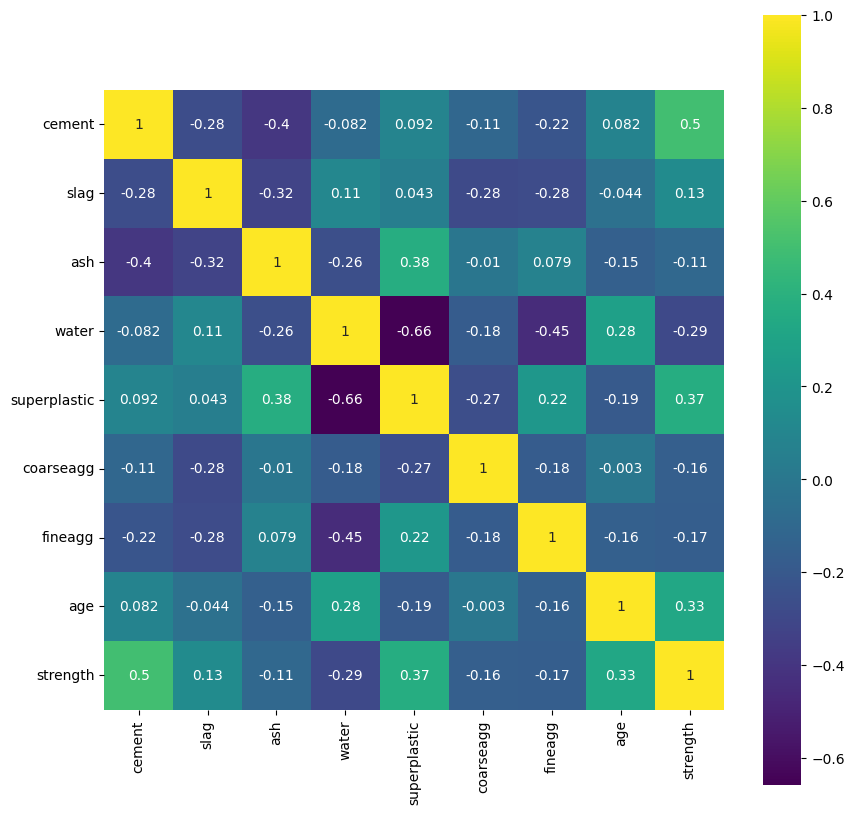

In [33]:
plt.figure(figsize=(10,10)) #se ajustará el tamaño de la figura
ax=sns.heatmap(data.corr(), vmax=1, square=True, annot=True, cmap="viridis") #se creará un mapa de calor de la correlación de los datos

Valores cercanos a 1 indican una correlación lineal positiva fuerte. Cuando una variable aumenta, la otra también tiende a aumentar.
Valores cercanos a -1 indican una correlación lineal negativa fuerte. Cuando una variable aumenta, la otra tiende a disminuir.
Valores cercanos a 0 indican una correlación lineal débil o nula.

1) Agua y Superplastificante: Correlación negativa fuerte (-0.66). Esto es interesante y podría indicar que el superplastificante se utiliza para reducir la cantidad de agua necesaria en la mezcla.
2) Cemento : Correlación positiva moderada (0.5). Esto sugiere que a mayor cantidad de cemento, mayor tiende a ser la resistencia del concreto, valiado si y solo si se mantiene un balance en A/C y los agregados, Un exceso de cemento sin el ajuste correcto puede afectar la manejabilidad, la compactación y, en última instancia, la durabilidad del concreto.
3) la alta relación entre caracteristicas puede ser redundante, ya que aporta información similar a la otra. Esto puede hacer que el modelo sea más complejo de lo necesario y dificultar la interpretación de los resultados. (por ahora, se debe pensar en eliminar una de esas caracteristicas agua o Superplastificante, pero sigue siendo curioso )



Correlación entre agua y superplastificante: -0.6575329076284468


<Axes: xlabel='water', ylabel='superplastic'>

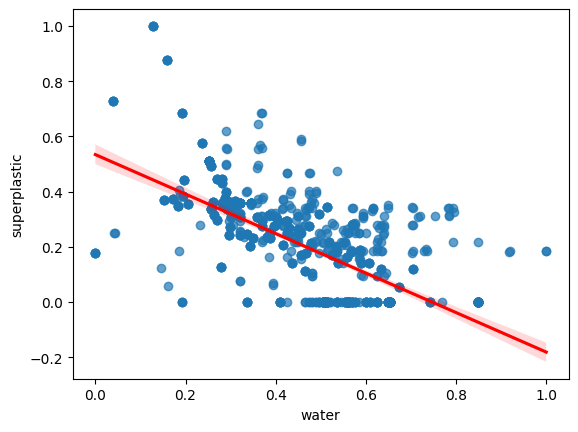

In [34]:
correlation = data['water'].corr(data['superplastic'])
print(f"Correlación entre agua y superplastificante: {correlation}")
sns.regplot(x='water', y='superplastic', data=data, scatter_kws={'alpha': 0.7}, line_kws={'color': 'red'})

1) Relación agua/cemento y resistencia:
Está ampliamente documentado (y respaldado por estudios) que la resistencia a la compresión del concreto es muy sensible a la relación agua/cemento. En general, cuanto menor sea esta relación, mayor será la resistencia, ya que se reduce la porosidad en la pasta de cemento

2) Función del superplastificante:
El superplastificante se utiliza precisamente para lograr que se mantenga una trabajabilidad adecuada a pesar de usar menos agua. Es decir, permite disminuir la cantidad de agua en la mezcla sin afectar (o incluso mejorando) la facilidad de colocación del concreto. Así, al reducir la cantidad de agua se obtiene una mezcla con menor relación agua/cemento y, por consiguiente, mayor resistencia y durabilidad.

3) No se trata de que el contenido de agua y la dosis de superplastificante tengan una correlación directa (por ejemplo, aumentando el superplastificante la cantidad de agua sube o baja de forma lineal). Más bien, el superplastificante es una herramienta para “compensar” la reducción de agua necesaria para alcanzar una baja relación agua/cemento sin sacrificar la trabajabilidad.

4) sigue siendo cursioso, por ende, haré un Feature Selection para analizar un poco mas, por que esta alta correlación entre caracteristicas pueden generar ruido.

Mejor alpha usando LassoCV: 0.00198241825046452
Mejor score usando LassoCV: 0.6154962840574827
Lasso escogió 8 variables y eliminó 0 variables


C:\Users\ardil\AppData\Local\Temp\ipykernel_22336\716696203.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=imp_coef.values, y=imp_coef.index, palette='viridis')


Text(0.5, 1.0, 'Coeficientes en el modelo Lasso')

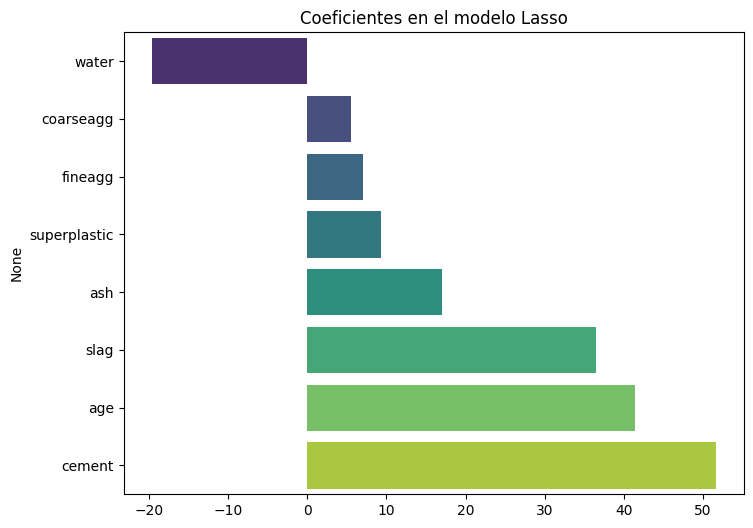

In [54]:


X = data.drop('strength', axis=1).values  # Características
Y = data['strength'].values  # Clase

reg=LassoCV() # Se crea un objeto de la clase LassoCV
reg.fit(X,Y) # Se ajusta el modelo
print(f"Mejor alpha usando LassoCV: {reg.alpha_}")
print(f"Mejor score usando LassoCV: {reg.score(X,Y)}")
coef = pd.Series(reg.coef_, index = data.drop('strength', axis=1).columns) # Se crea una serie con los coeficientes
print(f"Lasso escogió {sum(coef != 0)} variables y eliminó {sum(coef == 0)} variables")

imp_coef = coef.sort_values() # Se ordenan los coeficientes
plt.rcParams['figure.figsize'] = (7.0, 5.0) # Se ajusta el tamaño de la figura
plt.figure(figsize=(8, 6))  # Ajusta el tamaño de la figura
sns.barplot(x=imp_coef.values, y=imp_coef.index, palette='viridis')
plt.title("Coeficientes en el modelo Lasso")



1) Cemento (cement): Tiene el coeficiente positivo más alto. Esto confirma que el cemento es el ingrediente más importante para la resistencia del concreto, lo cual es consistente con el conocimiento previo en ingeniería civil.

2) Edad (age): También tiene un coeficiente positivo alto, aunque menor que el cemento. Esto indica que la edad es un factor relevante en el aumento de la resistencia del concreto con el tiempo, tiempo de fraguado (pero tambien depende del metodo de fraguado)

3) Escoria (slag) y ceniza (ash): Tienen coeficientes positivos, aunque más pequeños. Esto sugiere que estos materiales también contribuyen a la resistencia, aunque en menor medida que el cemento y la edad.

4) Superplastificante (superplastic): Tiene un coeficiente positivo pequeño, lo que indica una ligera influencia en la resistencia.

5) Agua (water): Tienen coeficientes negativos. Esto sugiere que un exceso de agua o de alguno de los agregados podría tener un impacto negativo en la resistencia del concreto.


La “correlación” entre agua y superplastificante no es directa en el sentido de que ambos se miden como variables independientes, sino que el superplastificante se emplea para ajustar (reducir) la cantidad de agua, y su efecto se refleja en la mejora de la relación agua/cemento y, por ende, en la resistencia.

Por ende, todas las caracteristicas aportan a nuestro modelo, y se opten por dejarlas todas.
